# A Machine Learning Approach to Understanding Older Adults' Trust in Assistive Robots

This notebook contains the analysis and supervised machine learning models used to investigate how older adults' prior experiences with technology influence their trust in assistive robots.

The study was conducted as part of an independent research project in the **Human Factors and Aging Laboratory at the University of Illinois Urbana-Champaign**, and was presented at the **Illinois Undergraduate Research Symposium** in April 2024.

---

## Contents

1. [Data Overview](#data-overview)
2. [Exploratory Data Analysis](#exploratory-data-analysis)
3. [Feature Engineering](#feature-engineering)
4. [Modeling](#modeling)
    - [L1: Lasso Regression](#lasso)
5. [Model Evaluation](#model-evaluation)
6. [Key Findings](#key-findings)

## Problem Definition

blah

## Data Collection

- 

## Imports

In [2]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor  # multicollinearity checks

from IPython.display import display

import os

# Suppress sklearn warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set seaborn theme for plots
sns.set_theme()

# Prevent dataframe columns from being hidden
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

### Helper function definitions

In [48]:
# Mapping dictionary for column descriptions
def get_phrase(metric: str, category: str) -> str:
    if metric == "FAMILIARITY":
        prefix = "familiarity with "
        if category == "Autonomous Car":
            suffix = "autonomous cars"
        elif category == "Paro":
            suffix = "Paro (a therapeutic seal robot)"
        else:
            suffix = f"{category} robots"
    else:  # TRUST
        if category in ["Count On", "Depend On"]:
            prefix = "something they can "
            suffix = category.lower()
        elif category == "Faith":
            prefix = ""
            suffix = "something they have faith in"
        else:
            prefix = ""
            suffix = category.lower()

    return f"{prefix}{suffix}".lower()

def get_familiarity_scale(rating: int):
    return {
        # 1: "not sure what this robot is",
        # 2: "never heard about, seen, or used this robot",
        # 3: "have only heard about or seen this robot",
        # 4: "have used or operated this robot only occasionally",
        # 5: "have used or operated this robot frequently",
        # 0: "No response"
        0: "No response",
        1: "Not sure",
        2: "Never heard",
        3: "Seen/heard",
        4: "Used occasionally",
        5: "Used frequently",
    }.get(rating)


## Exploratory Data Analysis

### Data Cleaning and Preprocessing

In [49]:
# Mapping study keys to data filenames; add more files here to expand dataset
studies = {
    "Mobility Impairment":  "mobility_impairment",
    "Visual Impairment":    "visual_impairment",
    "Surgery Recovery":     "surgery_recovery",
}

# Load data from all studies and combine
df = pd.DataFrame()
for study, filename in studies.items():
    path = os.path.join("..", "data", f"familiarity_and_trust_data_{filename}.csv")
    try:
        df_study = pd.read_csv(path)
        df_study["Study"] = study
        df = pd.concat([df, df_study], ignore_index=True)
    except FileNotFoundError:
        print(f"File not found: {path}\n")
    except Exception as e:
        print(f"Failed to load {study}: {e}\n")

num_par_i = df.shape[0]
print(f"Familiarity and Trust data loaded for {num_par_i} participants across {df['Study'].nunique()} studies.")

# Drop incomplete responses
df.dropna(inplace=True, ignore_index=True)

# Convert rating columns to integer values
df = df.convert_dtypes()

num_par_f = df.shape[0]
print(f"Removed {num_par_i - num_par_f} participants due to incomplete familiarity or trust data.")
print(f"Final dataset includes {num_par_f} participants.")
print(f"Null values remaining in dataset: {df.isnull().sum().sum()}\n")

# Optional: Study-wise counts
print("Participant counts by study:")
print(df['Study'].value_counts().to_string())

# # Preview data
# print("\nPreview of filtered raw data:")
# display(df.head())

Familiarity and Trust data loaded for 63 participants across 3 studies.
Removed 16 participants due to incomplete familiarity or trust data.
Final dataset includes 47 participants.
Null values remaining in dataset: 0

Participant counts by study:
Study
Mobility Impairment    29
Surgery Recovery       10
Visual Impairment       8


In [50]:
"""
Reformat column headers into a hierarchical structure:
- Column headers with a colon-separated format (e.g., "FAMILIARITY: Home") 
  are split into two levels: ("FAMILIARITY", "Home")
- All other columns are included under the "OTHER" category and retain their column name
"""
df.columns = pd.MultiIndex.from_tuples(
    [col.split(": ") if ": " in col else ("OTHER", col) for col in df.columns]
)

# Preview categorized data
print("Preview of categorized data:")
display(df.head())

Preview of categorized data:


FAMILIARITY                                                       \
  Autonomous Car Home Toy Manufacturing Military Paro Remote Presence   
0              1    2   1             1        1    1               1   
1              3    4   3             3        3    3               2   
2              3    3   3             3        3    2               2   
3              3    3   3             3        3    3               1   
4              3    3   3             3        3    3               1   

                                                 TRUST                     \
  Research Lawn Guard Space Surgical Unmanned Count On Depend On Reliable   
0        1    1     1     1        1        1        1         1        1   
1        3    2     3     3        3        2        4         3        4   
2        3    3     2     3        3        3        4         4        3   
3        3    3     1     3        3        3        4         4        4   
4        3    2     2     3        3        3        4         4        4   

                                                              OTHER  
  Faith  Capable  Diligent  Rigorous Accurate                 Study  
0      1        1         1        1         1  Mobility Impairment  
1      4        4         4        3         4  Mobility Impairment  
2      4        4         4        4         2  Mobility Impairment  
3      4        4         4        4         4  Mobility Impairment  
4      4        4         3        3         3  Mobility Impairment

In [51]:
# Standard descriptive statistics
desc = df.describe()

# Add unique counts for each column
nunique = pd.DataFrame(df.nunique()).T
nunique.index = ['unique']
desc = pd.concat([desc, nunique])

print("Dataset summary statistics:")
display(desc)

Dataset summary statistics:


FAMILIARITY                                                        \
       Autonomous Car      Home       Toy Manufacturing  Military      Paro   
count            47.0      47.0      47.0          47.0      47.0      47.0   
mean         2.531915  3.170213  2.723404      2.723404  2.553191  2.021277   
std          0.717819   0.89246  1.015149      0.649486  0.618853  0.920524   
min               1.0       2.0       0.0           1.0       1.0       0.0   
25%               2.0       3.0       2.0           2.0       2.0       1.0   
50%               3.0       3.0       3.0           3.0       3.0       2.0   
75%               3.0       4.0       3.0           3.0       3.0       3.0   
max               3.0       5.0       5.0           4.0       3.0       3.0   
unique            3.0       4.0       6.0           4.0       3.0       4.0   

                                                                          \
       Remote Presence  Research      Lawn     Guard     Space  Surgical   
count             47.0      47.0      47.0      47.0      47.0      47.0   
mean          1.638298  2.276596  2.468085  2.021277  2.723404  2.787234   
std           0.895048  0.852162  0.717819  0.846716  0.497914  0.549156   
min                0.0       0.0       0.0       1.0       1.0       1.0   
25%                1.0       2.0       2.0       1.0       2.5       3.0   
50%                1.0       3.0       3.0       2.0       3.0       3.0   
75%                2.0       3.0       3.0       3.0       3.0       3.0   
max                4.0       3.0       4.0       4.0       3.0       4.0   
unique             5.0       4.0       5.0       4.0       3.0       4.0   

                     TRUST                                                    \
        Unmanned  Count On Depend On  Reliable    Faith   Capable  Diligent    
count       47.0      47.0      47.0      47.0      47.0      47.0      47.0   
mean    2.595745  3.723404  3.659574  3.595745  3.489362  3.680851  3.617021   
std     0.711996  0.877301  0.961805    0.7419  0.804129   0.72551  0.795454   
min          1.0       1.0       1.0       1.0       1.0       1.0       1.0   
25%          2.0       3.0       3.0       3.0       3.0       3.0       3.0   
50%          3.0       4.0       4.0       4.0       4.0       4.0       4.0   
75%          3.0       4.0       4.0       4.0       4.0       4.0       4.0   
max          4.0       5.0       5.0       5.0       5.0       5.0       5.0   
unique       4.0       5.0       5.0       5.0       5.0       5.0       5.0   

                           OTHER  
        Rigorous Accurate  Study  
count       47.0      47.0   NaN  
mean    3.553191  3.702128   NaN  
std     0.746252  0.831836   NaN  
min          1.0       1.0   NaN  
25%          3.0       3.0   NaN  
50%          4.0       4.0   NaN  
75%          4.0       4.0   NaN  
max          5.0       5.0   NaN  
unique       5.0       5.0   3.0

In [54]:
trust_long = df["TRUST"].melt(var_name="Robot", value_name="Rating")

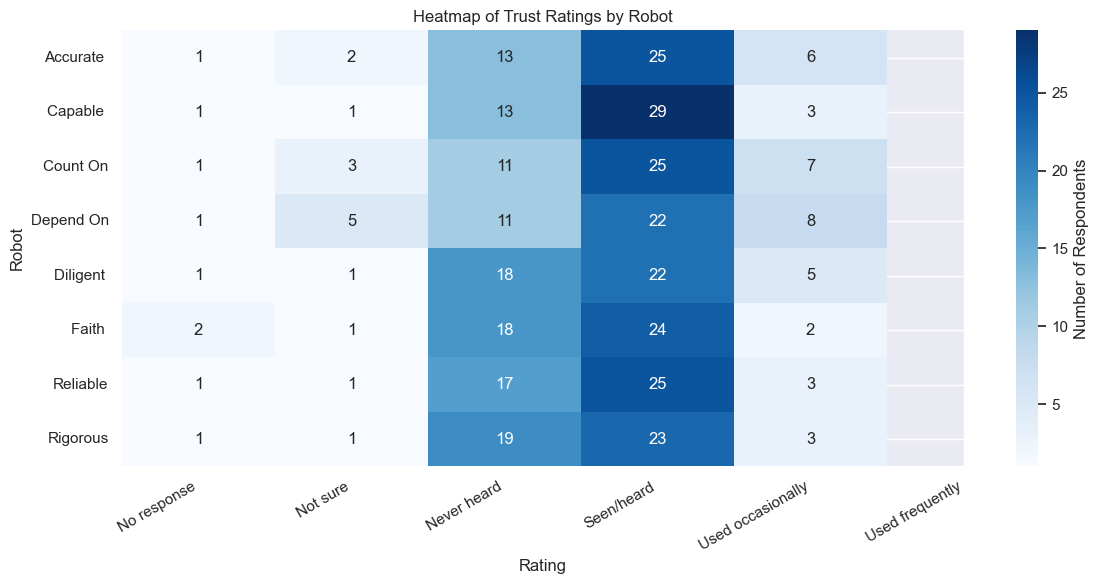

In [57]:
# Prepare data (same as above)
trust_heatmap_data = trust_long.groupby(["Robot", "Rating"]).size().unstack(fill_value=0)
trust_heatmap_data = trust_heatmap_data[[1, 2, 3, 4, 5]]  # Ensure rating order

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(trust_heatmap_data, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Number of Respondents'})
plt.title("Heatmap of Trust Ratings by Robot")
plt.xlabel("Rating")
plt.ylabel("Robot")
plt.xticks(ticks=[i + 0.5 for i in range(6)], labels=[get_familiarity_scale(i) for i in range(6)], rotation=30, ha='right')
plt.tight_layout()
plt.show()


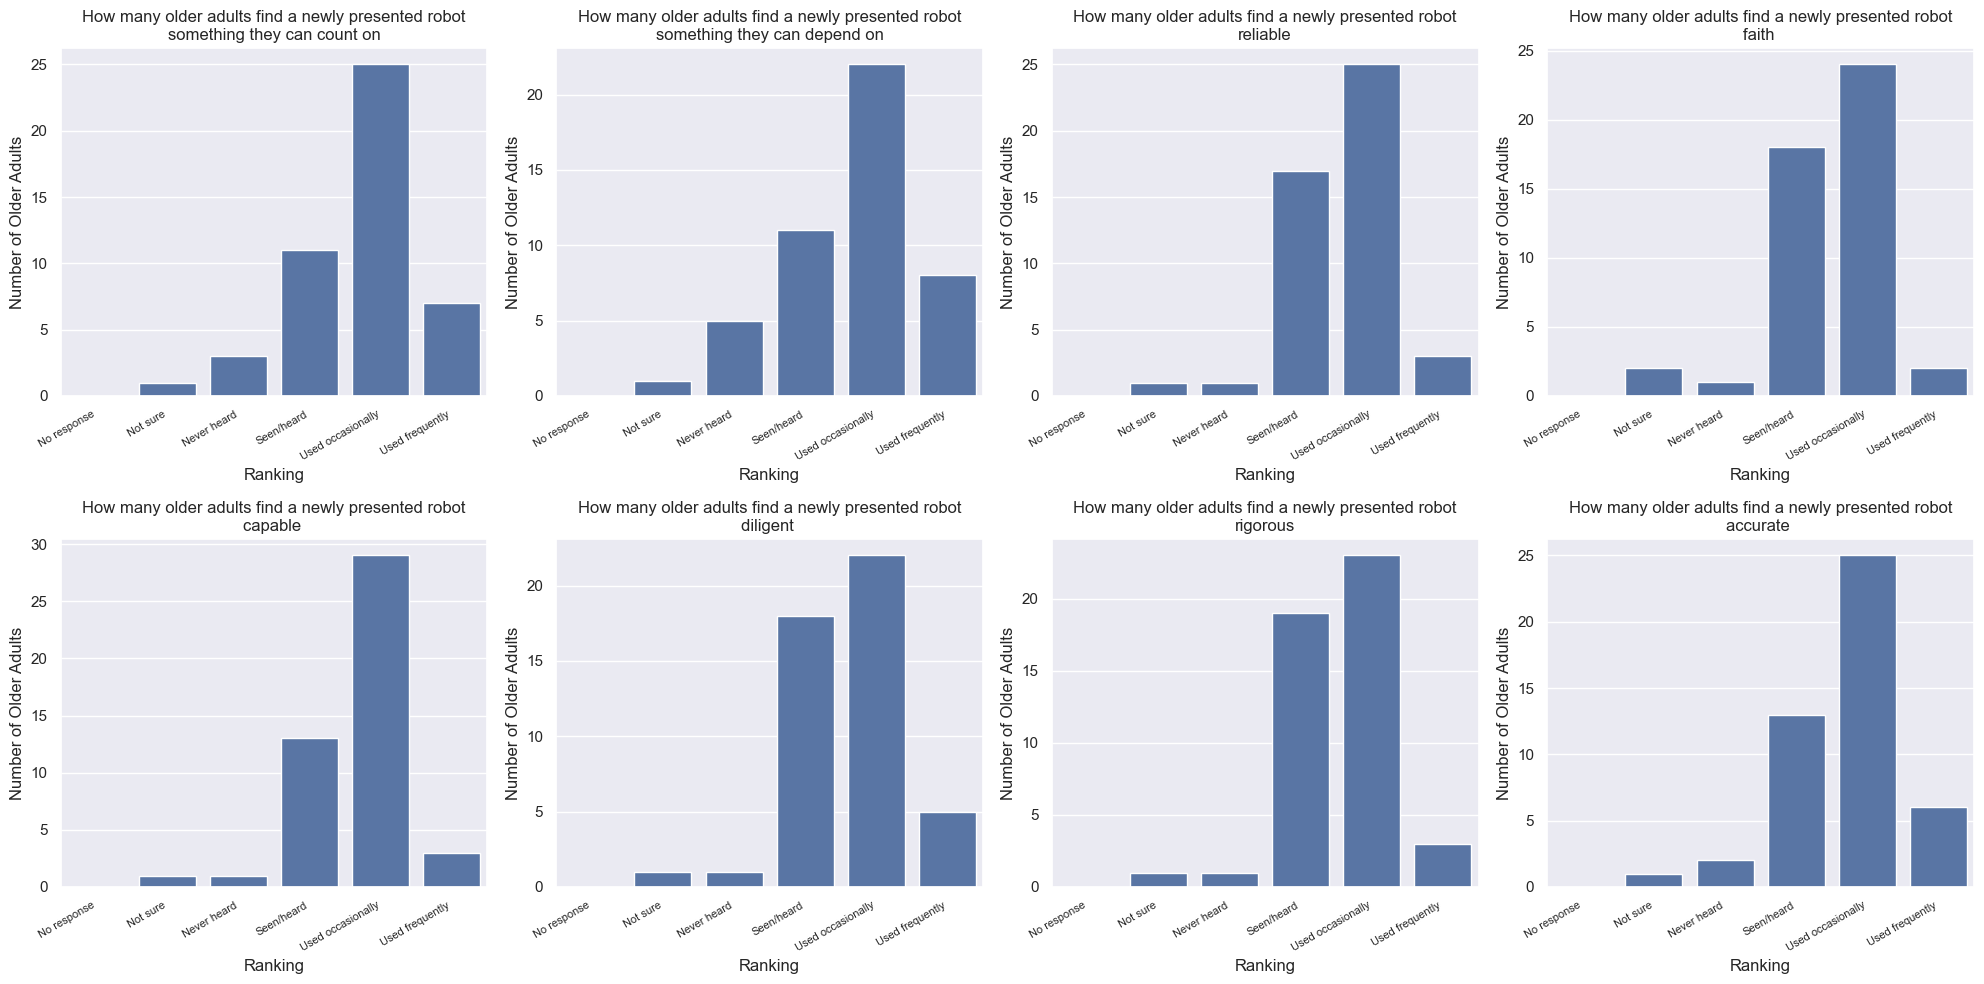

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()  # Make it easier to index in a single loop

for i, col in enumerate(df["TRUST"].columns):
    ax = axes[i]
    sns.countplot(x=df["TRUST"][col], order=[0, 1, 2, 3, 4, 5], ax=ax)
    ax.set_title("How many older adults find a newly presented robot\n" + get_phrase("TRUST", col))
    ax.set_xlabel("Ranking")
    ax.set_ylabel("Number of Older Adults")

    # Set long-form tick labels
    tick_labels = [get_familiarity_scale(tick) for tick in [0, 1, 2, 3, 4, 5]]
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_xticklabels(tick_labels, rotation=30, ha='right', fontsize=8)

# Hide any unused subplots if there are fewer than 8
for j in range(len(df["TRUST"].columns), 8):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Model Building

## Model Evaluation

## Results

## Future Work

In [52]:
studydata = df.drop(columns = "Participant ID")
FamVars = ["FAMILIARITY: Autonomous Car", "FAMILIARITY: Home", "FAMILIARITY: Toy", "FAMILIARITY: Manufacturing", "FAMILIARITY: Military", "FAMILIARITY: Paro",
           "FAMILIARITY: Remote Presence", "FAMILIARITY: Research", "FAMILIARITY: Lawn", "FAMILIARITY: Guard", "FAMILIARITY: Space", "FAMILIARITY: Surgical",
           "FAMILIARITY: Unmanned"]


In [53]:
studydata["Trust Mean Total"] = (studydata["TRUST: Accurate "] + studydata["TRUST: Capable "] + studydata["TRUST: Count On"] + studydata["TRUST: Depend On"] #rename total
                           + studydata["TRUST: Diligent "] + studydata["TRUST: Faith "]   + studydata["TRUST: Reliable"] + studydata["TRUST: Rigorous"])/8
studydata["Trust Mean Capacity"] = (studydata["TRUST: Accurate "] + studydata["TRUST: Capable "] + studydata["TRUST: Diligent "] + studydata["TRUST: Rigorous"])/4
studydata["Trust Mean Relation"] = (studydata["TRUST: Count On"] + studydata["TRUST: Depend On"] + studydata["TRUST: Faith "] + studydata["TRUST: Reliable"])/4
TruVars = ["Trust Mean Total", "Trust Mean Capacity", "Trust Mean Relation"]
studydata.head()

,STUDY,FAMILIARITY: Autonomous Car,FAMILIARITY: Home,FAMILIARITY: Toy,FAMILIARITY: Manufacturing,FAMILIARITY: Military,FAMILIARITY: Paro,FAMILIARITY: Remote Presence,FAMILIARITY: Research,FAMILIARITY: Lawn,...,TRUST: Depend On,TRUST: Reliable,TRUST: Faith,TRUST: Capable,TRUST: Diligent,TRUST: Rigorous,TRUST: Accurate,Trust Mean Total,Trust Mean Capacity,Trust Mean Relation
0,Visual Impairment,3.0,3.0,3.0,3.0,2.0,1.0,1.0,3.0,3.0,...,4.0,4.0,4.0,4.0,4.0,3.0,4.0,3.875,3.75,4.00
1,Visual Impairment,3.0,5.0,3.0,3.0,3.0,1.0,1.0,1.0,2.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.000,4.00,4.00
2,Visual Impairment,3.0,2.0,0.0,3.0,3.0,1.0,2.0,2.0,2.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.000,4.00,4.00
9,Visual Impairment,3.0,3.0,3.0,3.0,3.0,1.0,1.0,2.0,2.0,...,4.0,4.0,4.0,4.0,3.0,4.0,4.0,3.875,3.75,4.00
10,Visual Impairment,3.0,2.0,1.0,3.0,3.0,1.0,1.0,1.0,3.0,...,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.250,3.25,3.25


In [54]:
# plot1 = sns.boxplot(data = studydata)
# plot1.set_xticklabels(plot1.get_xticklabels(), rotation=90)
# plt.show()

In [55]:
# studydata_noout = studydata[(studydata["Mean Trust"]>1)]
# studydata_noout.head()
# studydata_noout.shape

In [56]:
# #Outlier Inspection
# sns.pairplot(studydata)
# plt.show()

In [57]:
# studydata.drop(columns=["STUDY"]).corr()

In [58]:
modeldata = studydata[FamVars + TruVars]
modeldata.head()

,FAMILIARITY: Autonomous Car,FAMILIARITY: Home,FAMILIARITY: Toy,FAMILIARITY: Manufacturing,FAMILIARITY: Military,FAMILIARITY: Paro,FAMILIARITY: Remote Presence,FAMILIARITY: Research,FAMILIARITY: Lawn,FAMILIARITY: Guard,FAMILIARITY: Space,FAMILIARITY: Surgical,FAMILIARITY: Unmanned,Trust Mean Total,Trust Mean Capacity,Trust Mean Relation
0,3.0,3.0,3.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,3.0,3.0,3.875,3.75,4.00
1,3.0,5.0,3.0,3.0,3.0,1.0,1.0,1.0,2.0,2.0,3.0,3.0,3.0,4.000,4.00,4.00
2,3.0,2.0,0.0,3.0,3.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,4.000,4.00,4.00
9,3.0,3.0,3.0,3.0,3.0,1.0,1.0,2.0,2.0,3.0,3.0,3.0,3.0,3.875,3.75,4.00
10,3.0,2.0,1.0,3.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,3.0,3.0,3.250,3.25,3.25


In [59]:
modeldata_total = modeldata.drop(columns=["Trust Mean Capacity", "Trust Mean Relation"])
modeldata_capacity = modeldata.drop(columns=["Trust Mean Total", "Trust Mean Relation"])
modeldata_relation = modeldata.drop(columns=["Trust Mean Total", "Trust Mean Capacity"])

## Checking for Multicollinearity

In [60]:
def calc_vif(data):
    vif = pd.DataFrame()
    vif["variables"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range (data.shape[1])]
    return vif

In [61]:
x = modeldata.drop(columns=["Trust Mean Total", "Trust Mean Capacity", "Trust Mean Relation"])
calc_vif(x)

,variables,VIF
0,FAMILIARITY: Autonomous Car,23.378100
1,FAMILIARITY: Home,20.198551
2,FAMILIARITY: Toy,32.574338
3,FAMILIARITY: Manufacturing,94.972136
4,FAMILIARITY: Military,58.885281
5,FAMILIARITY: Paro,13.677995
6,FAMILIARITY: Remote Presence,7.890076
7,FAMILIARITY: Research,21.217564
8,FAMILIARITY: Lawn,35.345627
9,FAMILIARITY: Guard,17.153140


Very high evidence of multicollinearity (VIF values >> 10 for many values)

There are 2 different types of models we can use to minimize the effects of multicollinearity. LASSO models will work best when we have many explanatory variables but only some have direct impact on the dependent variable. RIDGE models will work best if we have many explanatory variables that all have some sort of impact on the dependent. LASSO will yield a simpler model, so we can start there.

## Overall Trust Lasso

In [62]:
x_total = modeldata_total.drop(columns=["Trust Mean Total"])
y_total = modeldata_total[["Trust Mean Total"]]

#Will want to compare magnitude of slopes in linear regression models to try to infer the corresponding explanatory variable's important when it comes to predicting Mean Trust.
#So we will z-score the features matrices
scaler = StandardScaler()
x_total_sc = scaler.fit_transform(x_total)
x_total_sc = pd.DataFrame(x_total_sc, columns = x_total.columns)
x_total_sc.head()

,FAMILIARITY: Autonomous Car,FAMILIARITY: Home,FAMILIARITY: Toy,FAMILIARITY: Manufacturing,FAMILIARITY: Military,FAMILIARITY: Paro,FAMILIARITY: Remote Presence,FAMILIARITY: Research,FAMILIARITY: Lawn,FAMILIARITY: Guard,FAMILIARITY: Space,FAMILIARITY: Surgical,FAMILIARITY: Unmanned
0,0.659144,-0.192785,0.275414,0.430473,-0.903562,-1.121446,-0.720854,0.858083,0.749027,-0.025400,0.561514,0.39163,0.573916
1,0.659144,2.072440,0.275414,0.430473,0.729800,-1.121446,-0.720854,-1.514263,-0.659144,-0.025400,0.561514,0.39163,0.573916
2,0.659144,-1.325397,-2.711767,0.430473,0.729800,-1.121446,0.408484,-0.328090,-0.659144,-0.025400,0.561514,0.39163,0.573916
3,0.659144,-0.192785,0.275414,0.430473,0.729800,-1.121446,-0.720854,-0.328090,-0.659144,1.168401,0.561514,0.39163,0.573916
4,0.659144,-1.325397,-1.716040,0.430473,0.729800,-1.121446,-0.720854,-1.514263,0.749027,-1.219201,0.561514,0.39163,0.573916


In [63]:
lasso_list=[]
for i in np.arange(0,0.25,0.01):
    temp_lasso = Lasso(alpha=i, max_iter=1000)
    temp_lasso.fit(x_total_sc, y_total)
    lasso_list.append([i,temp_lasso.coef_.T[0], temp_lasso.coef_.T[1], temp_lasso.coef_.T[2], temp_lasso.coef_.T[3],
                         temp_lasso.coef_.T[4], temp_lasso.coef_.T[5], temp_lasso.coef_.T[6], temp_lasso.coef_.T[7],
                         temp_lasso.coef_.T[8], temp_lasso.coef_.T[9], temp_lasso.coef_.T[10], temp_lasso.coef_.T[11],
                         temp_lasso.coef_.T[12], temp_lasso.score(x_total_sc,y_total)])
lasso_list
total_lasso = pd.DataFrame(lasso_list)
total_lasso = total_lasso.rename(columns={0:"Lambda", 1: "Autonomous Car", 2: "Home", 3: "Toy", 4: "Manufacturing", 5: "Military", 
                                          6:"Paro", 7: "Remote Presence", 8: "Research", 9:"Lawn", 10: "Guard", 11: "Space", 12: "Surgical", 13:"Unmanned", 14: "R^2"}, errors="raise")

total_lasso

,Lambda,Autonomous Car,Home,Toy,Manufacturing,Military,Paro,Remote Presence,Research,Lawn,Guard,Space,Surgical,Unmanned,R^2
0,0.00,-0.043549,0.079426,0.001317,0.194290,0.036323,-0.057611,-0.056460,0.141771,-0.109153,-0.151261,0.315562,-0.337775,0.194433,0.281578
1,0.01,-0.014735,0.061773,-0.000000,0.207682,0.016486,-0.042018,-0.049467,0.097358,-0.080188,-0.098574,0.168040,-0.225258,0.182726,0.271065
2,0.02,-0.000000,0.045490,-0.000000,0.218887,0.000000,-0.024145,-0.046130,0.050273,-0.048429,-0.048121,0.029812,-0.115944,0.172076,0.241699
3,0.03,-0.000000,0.031429,-0.000000,0.192343,0.000000,-0.002723,-0.044562,0.000000,-0.017200,-0.010141,0.000000,-0.078897,0.160533,0.213374
4,0.04,-0.000000,0.016269,-0.000000,0.166148,0.000000,-0.001564,-0.032356,0.000000,-0.000539,-0.000000,0.000000,-0.062904,0.145128,0.195856
5,0.05,-0.000000,0.001761,0.000000,0.147720,0.000000,-0.000000,-0.017167,0.000000,-0.000000,-0.000000,0.000000,-0.037229,0.130158,0.177689
6,0.06,-0.000000,0.000000,0.000000,0.127674,0.000000,-0.000000,-0.004505,0.000000,-0.000000,-0.000000,0.000000,-0.012486,0.114826,0.159501
7,0.07,-0.000000,0.000000,0.000000,0.114554,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.103985,0.147989
8,0.08,0.000000,0.000000,0.000000,0.107910,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.097341,0.143558
9,0.09,0.000000,0.000000,0.000000,0.101265,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.090697,0.138535


In [64]:
lassobest_total = Lasso(alpha=0.02, max_iter=1000)
lassobest_total.fit(x_total_sc, y_total)
# lassobest_total.coef_.T
empty = []
for i in range (13):
    empty.append(lassobest_total.coef_.T[i])
df_slopes = pd.DataFrame({"LASSO_mod_0 coefficient":empty}, index=x_total.columns)
df_slopes

,LASSO_mod_0 coefficient
FAMILIARITY: Autonomous Car,-0.000000
FAMILIARITY: Home,0.045490
FAMILIARITY: Toy,-0.000000
FAMILIARITY: Manufacturing,0.218887
FAMILIARITY: Military,0.000000
FAMILIARITY: Paro,-0.024145
FAMILIARITY: Remote Presence,-0.046130
FAMILIARITY: Research,0.050273
FAMILIARITY: Lawn,-0.048429
FAMILIARITY: Guard,-0.048121


From this, we can deduce that the amount of predictive power brought by each explanatory variable to the linear regression model. I've ranked them below. Those that are "tied" bring about the same amounts of predictive power.

1. Manufacturing
2. Unmanned
3. Surgical + Remote Presence
4. 
5. Home
6. Paro + Lawn
7. 
8. Guard
9. Space + Research
10. 
11. Autonomous Car + Military
12. 
13. Toy


Future Work: more data, nonlinear models, find other studies that have used the questionnaires

## Capacity Based Trust

In [65]:
x_capacity = modeldata_capacity.drop(columns=["Trust Mean Capacity"])
y_capacity = modeldata_capacity[["Trust Mean Capacity"]]

scaler = StandardScaler()
x_capacity_sc = scaler.fit_transform(x_capacity)
x_capacity_sc = pd.DataFrame(x_capacity_sc, columns = x_capacity.columns)

lasso_list=[]
for i in np.arange(0,0.3,0.01):
    temp_lasso = Lasso(alpha=i, max_iter=1000)
    temp_lasso.fit(x_capacity_sc, y_capacity)
    lasso_list.append([i,temp_lasso.coef_.T[0], temp_lasso.coef_.T[1], temp_lasso.coef_.T[2], temp_lasso.coef_.T[3],
                         temp_lasso.coef_.T[4], temp_lasso.coef_.T[5], temp_lasso.coef_.T[6], temp_lasso.coef_.T[7],
                         temp_lasso.coef_.T[8], temp_lasso.coef_.T[9], temp_lasso.coef_.T[10], temp_lasso.coef_.T[11],
                         temp_lasso.coef_.T[12], temp_lasso.score(x_capacity_sc,y_capacity)])
lasso_list
capacity_lasso = pd.DataFrame(lasso_list)
capacity_lasso = capacity_lasso.rename(columns={0:"Lambda", 1: "Autonomous Car", 2: "Home", 3: "Toy", 4: "Manufacturing", 5: "Military", 
                                                6:"Paro", 7: "Remote Presence", 8: "Research", 9:"Lawn", 10: "Guard", 11: "Space", 12: "Surgical", 13:"Unmanned", 14: "R^2"}, errors="raise")

capacity_lasso

,Lambda,Autonomous Car,Home,Toy,Manufacturing,Military,Paro,Remote Presence,Research,Lawn,Guard,Space,Surgical,Unmanned,R^2
0,0.00,-0.012883,0.113639,-0.034128,0.330153,0.073559,-0.080046,-0.059152,0.105586,-0.022739,-0.106332,0.09144,-0.235533,0.080518,0.271670
1,0.01,0.000000,0.093316,-0.015106,0.318042,0.056187,-0.066519,-0.052528,0.061780,-0.000000,-0.063250,0.00000,-0.152248,0.068377,0.263765
2,0.02,0.000000,0.077399,-0.000000,0.284210,0.028262,-0.049141,-0.040743,0.023704,-0.000000,-0.027219,0.00000,-0.113804,0.059456,0.247471
3,0.03,0.000000,0.065484,-0.000000,0.260752,0.000000,-0.033372,-0.027379,0.000000,-0.000000,-0.000000,0.00000,-0.076875,0.050403,0.226705
4,0.04,0.000000,0.050991,-0.000000,0.242155,0.000000,-0.029036,-0.013215,0.000000,-0.000000,-0.000000,0.00000,-0.051513,0.035985,0.212289
5,0.05,0.000000,0.036698,-0.000000,0.223625,0.000000,-0.024361,-0.000000,0.000000,-0.000000,-0.000000,0.00000,-0.026060,0.021680,0.193955
6,0.06,0.000000,0.025226,0.000000,0.206298,0.000000,-0.014784,-0.000000,0.000000,-0.000000,-0.000000,-0.00000,-0.000000,0.009136,0.174890
7,0.07,0.000000,0.016333,0.000000,0.197750,0.000000,-0.000522,-0.000000,0.000000,-0.000000,-0.000000,0.00000,-0.000000,0.004213,0.164158
8,0.08,0.000000,0.008901,0.000000,0.192028,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.00000,-0.000000,0.000000,0.158137
9,0.09,0.000000,0.001256,0.000000,0.184383,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.00000,-0.000000,0.000000,0.152278


In [66]:
lassobest_capacity = Lasso(alpha=0.00, max_iter=1000)
lassobest_capacity.fit(x_capacity_sc, y_capacity)
lassobest_capacity.coef_.T

empty = []
for i in range (13):
    empty.append(lassobest_capacity.coef_.T[i])
df_slopes = pd.DataFrame({"LASSO_mod_0 coefficient":empty}, index=x_capacity.columns)

df_slopes

,LASSO_mod_0 coefficient
FAMILIARITY: Autonomous Car,-0.012883
FAMILIARITY: Home,0.113639
FAMILIARITY: Toy,-0.034128
FAMILIARITY: Manufacturing,0.330153
FAMILIARITY: Military,0.073559
FAMILIARITY: Paro,-0.080046
FAMILIARITY: Remote Presence,-0.059152
FAMILIARITY: Research,0.105586
FAMILIARITY: Lawn,-0.022739
FAMILIARITY: Guard,-0.106332


From this, we can deduce that the amount of predictive power brought by each explanatory variable to the linear regression model. I've ranked them below. Those that are "tied" bring about the same amounts of predictive power.

1. Manufacturing
2. Home
3. Unmanned + Paro
4. 
5. Surgical
6. Remote Presence
7. Guard + Military + Research
8. 
9. 
10. Toy
11. Space + Autonomous Car + Lawn Mower
12. 
13. 

## Relational Trust

In [67]:
x_relation = modeldata_relation.drop(columns=["Trust Mean Relation"])
y_relation = modeldata_relation[["Trust Mean Relation"]]

scaler = StandardScaler()
x_relation_sc = scaler.fit_transform(x_relation)
x_relation_sc = pd.DataFrame(x_relation_sc, columns = x_relation.columns)

lasso_list=[]
for i in np.arange(0,0.3,0.01):
    temp_lasso = Lasso(alpha=i, max_iter=1000)
    temp_lasso.fit(x_relation_sc, y_relation)
    lasso_list.append([i,temp_lasso.coef_.T[0], temp_lasso.coef_.T[1], temp_lasso.coef_.T[2], temp_lasso.coef_.T[3],
                         temp_lasso.coef_.T[4], temp_lasso.coef_.T[5], temp_lasso.coef_.T[6], temp_lasso.coef_.T[7],
                         temp_lasso.coef_.T[8], temp_lasso.coef_.T[9], temp_lasso.coef_.T[10], temp_lasso.coef_.T[11],
                         temp_lasso.coef_.T[12], temp_lasso.score(x_relation_sc,y_relation)])
lasso_list
relation_lasso = pd.DataFrame(lasso_list)
relation_lasso = relation_lasso.rename(columns={0:"Lambda", 1: "Autonomous Car", 2: "Home", 3: "Toy", 4: "Manufacturing", 5: "Military", 
                                                6:"Paro", 7: "Remote Presence", 8: "Research", 9:"Lawn", 10: "Guard", 11: "Space", 12: "Surgical", 13:"Unmanned", 14: "R^2"}, errors="raise")

relation_lasso

,Lambda,Autonomous Car,Home,Toy,Manufacturing,Military,Paro,Remote Presence,Research,Lawn,Guard,Space,Surgical,Unmanned,R^2
0,0.00,-0.074216,0.045213,0.036762,0.058426,-0.000913,-0.035176,-0.053768,0.177955,-0.195567,-0.196189,0.539684,-0.440016,0.308349,0.313373
1,0.01,-0.051688,0.034715,0.000000,0.100425,-0.000000,-0.010726,-0.052674,0.127378,-0.162547,-0.139907,0.360124,-0.314778,0.299088,0.304178
2,0.02,-0.022593,0.014060,0.000000,0.118662,0.000000,-0.000000,-0.046001,0.083047,-0.136655,-0.091257,0.199738,-0.200031,0.285350,0.278927
3,0.03,-0.000000,0.000000,0.000000,0.136807,0.000000,-0.000000,-0.037712,0.044062,-0.109922,-0.044487,0.043720,-0.086634,0.270146,0.240150
4,0.04,-0.000000,0.000000,0.000000,0.115840,0.000000,-0.000000,-0.032048,0.004166,-0.079111,-0.007974,0.000000,-0.041175,0.254887,0.210111
5,0.05,-0.000000,0.000000,0.000000,0.087639,-0.000000,-0.000000,-0.023337,0.000000,-0.059913,-0.000000,0.000000,-0.025078,0.238609,0.193594
6,0.06,-0.000000,0.000000,0.000000,0.061935,-0.000000,-0.000000,-0.014246,0.000000,-0.041971,-0.000000,0.000000,-0.007196,0.221852,0.175865
7,0.07,-0.000000,0.000000,0.000000,0.038301,-0.000000,-0.000000,-0.004381,0.000000,-0.019715,-0.000000,0.000000,-0.000000,0.207158,0.157319
8,0.08,-0.000000,0.000000,0.000000,0.020479,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.195810,0.142797
9,0.09,-0.000000,0.000000,0.000000,0.013835,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.189166,0.138630


In [68]:
lassobest_capacity = Lasso(alpha=0.00, max_iter=1000)
lassobest_capacity.fit(x_capacity_sc, y_capacity)
lassobest_capacity.coef_.T

empty = []
for i in range (13):
    empty.append(lassobest_capacity.coef_.T[i])
df_slopes = pd.DataFrame({"LASSO_mod_0 coefficient":empty}, index=x_capacity.columns)

df_slopes

,LASSO_mod_0 coefficient
FAMILIARITY: Autonomous Car,-0.012883
FAMILIARITY: Home,0.113639
FAMILIARITY: Toy,-0.034128
FAMILIARITY: Manufacturing,0.330153
FAMILIARITY: Military,0.073559
FAMILIARITY: Paro,-0.080046
FAMILIARITY: Remote Presence,-0.059152
FAMILIARITY: Research,0.105586
FAMILIARITY: Lawn,-0.022739
FAMILIARITY: Guard,-0.106332


From this, we can deduce that the amount of predictive power brought by each explanatory variable to the linear regression model. I've ranked them below. Those that are "tied" bring about the same amounts of predictive power.

1. Unmanned
2. Manufacturing
3. Lawn + Remote Presence
4. 
5. Surgical
6. Research + Guard
7. 
8. Space
9. Autonomous Car + Home
10. 
11. Paro
12. Military + Toy
13.  

## Ridge

## Overall

In [69]:
x_total = modeldata_total.drop(columns=["Trust Mean Total"])
y_total = modeldata_total[["Trust Mean Total"]]

#Will want to compare magnitude of slopes in linear regression models to try to infer the corresponding explanatory variable's important when it comes to predicting Mean Trust.
#So we will z-score the features matrices
scaler = StandardScaler()
x_total_sc = scaler.fit_transform(x_total)
x_total_sc = pd.DataFrame(x_total_sc, columns = x_total.columns)
x_total_sc.head()

,FAMILIARITY: Autonomous Car,FAMILIARITY: Home,FAMILIARITY: Toy,FAMILIARITY: Manufacturing,FAMILIARITY: Military,FAMILIARITY: Paro,FAMILIARITY: Remote Presence,FAMILIARITY: Research,FAMILIARITY: Lawn,FAMILIARITY: Guard,FAMILIARITY: Space,FAMILIARITY: Surgical,FAMILIARITY: Unmanned
0,0.659144,-0.192785,0.275414,0.430473,-0.903562,-1.121446,-0.720854,0.858083,0.749027,-0.025400,0.561514,0.39163,0.573916
1,0.659144,2.072440,0.275414,0.430473,0.729800,-1.121446,-0.720854,-1.514263,-0.659144,-0.025400,0.561514,0.39163,0.573916
2,0.659144,-1.325397,-2.711767,0.430473,0.729800,-1.121446,0.408484,-0.328090,-0.659144,-0.025400,0.561514,0.39163,0.573916
3,0.659144,-0.192785,0.275414,0.430473,0.729800,-1.121446,-0.720854,-0.328090,-0.659144,1.168401,0.561514,0.39163,0.573916
4,0.659144,-1.325397,-1.716040,0.430473,0.729800,-1.121446,-0.720854,-1.514263,0.749027,-1.219201,0.561514,0.39163,0.573916


In [70]:
lasso_list=[]
for i in np.arange(0,0.25,0.01):
    temp_lasso = Ridge(alpha=i, max_iter=1000)
    temp_lasso.fit(x_total_sc, y_total)
    lasso_list.append([i,temp_lasso.coef_.T[0], temp_lasso.coef_.T[1], temp_lasso.coef_.T[2], temp_lasso.coef_.T[3],
                         temp_lasso.coef_.T[4], temp_lasso.coef_.T[5], temp_lasso.coef_.T[6], temp_lasso.coef_.T[7],
                         temp_lasso.coef_.T[8], temp_lasso.coef_.T[9], temp_lasso.coef_.T[10], temp_lasso.coef_.T[11],
                         temp_lasso.coef_.T[12], temp_lasso.score(x_total_sc,y_total)])
lasso_list
total_lasso = pd.DataFrame(lasso_list)
total_lasso = total_lasso.rename(columns={0:"Lambda", 1: "Autonomous Car", 2: "Home", 3: "Toy", 4: "Manufacturing", 5: "Military", 
                                          6:"Paro", 7: "Remote Presence", 8: "Research", 9:"Lawn", 10: "Guard", 11: "Space", 12: "Surgical", 13:"Unmanned", 14: "R^2"}, errors="raise")

total_lasso

,Lambda,Autonomous Car,Home,Toy,Manufacturing,Military,Paro,Remote Presence,Research,Lawn,Guard,Space,Surgical,Unmanned,R^2
0,0.00,[-0.04354944428485938],[0.07942610157465745],[0.0013167743225970094],[0.1942896008749879],[0.03632330690144904],[-0.05761117511370974],[-0.0564600024391609],[0.14177070023509902],[-0.10915293325942055],[-0.15126064562780583],[0.3155621758859031],[-0.3377745982983035],[0.19443317269888802],0.281578
1,0.01,[-0.04345787633305847],[0.07938846158046176],[0.001215465361887209],[0.19463605954946064],[0.03637524500459683],[-0.057584364328632585],[-0.05649187381884623],[0.14162270386409698],[-0.10908657239291002],[-0.15107026501779547],[0.3143485176407002],[-0.33687374010709925],[0.19437378329727034],0.281577
2,0.02,[-0.0433668604593182],[0.07935083668243972],[0.0011157600985005768],[0.19497787392796717],[0.03642650072520545],[-0.05755767009893612],[-0.0565233750807281],[0.14147504184112278],[-0.10902009828076364],[-0.15088074252186603],[0.31314531352962727],[-0.3359799765474827],[0.19431451155592386],0.281576
3,0.03,[-0.04327639001261762],[0.07931322751242394],[0.0010176349597977325],[0.19531510916965572],[0.03647708310976747],[-0.05753109109369513],[-0.056554510863371175],[0.14132771235899536],[-0.10895351396347673],[-0.15069206874315585],[0.3119524265738852],[-0.3350932157733745],[0.19425535620178475],0.281575
4,0.04,[-0.043186458455988425],[0.07927563468751174],[0.0009210667966388182],[0.19564782927870186],[0.03652700104876084],[-0.05750462600511455],[-0.05658528572550682],[0.1411807136333424],[-0.1088868224239542],[-0.1505042344438672],[0.31076972218983295],[-0.33421336754241593],[0.19419631598386483],0.281572
5,0.05,[-0.04309705936404335],[0.07923805881040982],[0.0008260328740886839],[0.19597609712955175],[0.03657626328002489],[-0.057478273548018884],[-0.056615704147769244],[0.14103404390213795],[-0.10882002658877594],[-0.15031723054181534],[0.3095970681367927],[-0.3333403431810255],[0.19413738967277103],0.281570
6,0.06,[-0.043008186420568466],[0.07920050046976959],[0.0007325108623633867],[0.19629997449150613],[0.03662487839204553],[-0.057452032459354783],[-0.05664577053438462],[0.14088770142525175],[-0.10875312932943229],[-0.15013104810706487],[0.30843433446621926],[-0.33247405555036724],[0.19407857606024026],0.281566
7,0.07,[-0.04291983341617813],[0.07916296024051395],[0.0006404788280131371],[0.1966195220526677],[0.03667285482715956],[-0.057425901497706724],[-0.056675489214818776],[0.14074168448401014],[-0.10868613346352475],[-0.14994567835865624],[0.3072813934721821],[-0.33161441901319955],[0.19401987395868395],0.281562
8,0.08,[-0.04283199424602985],[0.07912543868415493],[0.0005499152253318722],[0.19693479944327025],[0.03672020088467341],[-0.05739987944282479],[-0.056704864445380386],[0.1405959913807678],[-0.10861904175593741],[-0.14976111266141365],[0.30613811964312587],[-0.33076134940157986],[0.19396128220074665],0.281558
9,0.09,[-0.04274466290759868],[0.07908793634910372],[0.0004607988879909185],[0.1972458652584021],[0.03676692472390228],[-0.05737396509516524],[-0.05673390041078403],[0.14045062043849035],[-0.10855185691997657],[-0.1495773425228377],[0.30500438961488324],[-0.3299147639854065],[0.19390279963887347],0.281553


In [73]:
lassobest_total = Ridge(alpha=0.24, max_iter=1000)
lassobest_total.fit(x_total_sc, y_total)
# lassobest_total.coef_.T
empty = []
for i in range (13):
    empty.append(lassobest_total.coef_.T[i])
df_slopes = pd.DataFrame({"LASSO_mod_0 coefficient":empty}, index=x_total.columns)
df_slopes

,LASSO_mod_0 coefficient
FAMILIARITY: Autonomous Car,[-0.041491840205873716]
FAMILIARITY: Home,[0.07852804401413704]
FAMILIARITY: Toy,[-0.0007155959952537378]
FAMILIARITY: Manufacturing,[0.20144338353580613]
FAMILIARITY: Military,[0.03739826859015988]
FAMILIARITY: Paro,[-0.05699741750869014]
FAMILIARITY: Remote Presence,[-0.05713137130821436]
FAMILIARITY: Research,[0.13830763384355577]
FAMILIARITY: Lawn,[-0.10753460839434278]
FAMILIARITY: Guard,[-0.1469108859387322]


In [ ]:
1. Surgical
1. Space
1. Manufacturing
2. Unmanned

## Capacity Ridge

In [74]:
x_capacity = modeldata_capacity.drop(columns=["Trust Mean Capacity"])
y_capacity = modeldata_capacity[["Trust Mean Capacity"]]

scaler = StandardScaler()
x_capacity_sc = scaler.fit_transform(x_capacity)
x_capacity_sc = pd.DataFrame(x_capacity_sc, columns = x_capacity.columns)

lasso_list=[]
for i in np.arange(0,0.3,0.01):
    temp_lasso = Ridge(alpha=i, max_iter=1000)
    temp_lasso.fit(x_capacity_sc, y_capacity)
    lasso_list.append([i,temp_lasso.coef_.T[0], temp_lasso.coef_.T[1], temp_lasso.coef_.T[2], temp_lasso.coef_.T[3],
                         temp_lasso.coef_.T[4], temp_lasso.coef_.T[5], temp_lasso.coef_.T[6], temp_lasso.coef_.T[7],
                         temp_lasso.coef_.T[8], temp_lasso.coef_.T[9], temp_lasso.coef_.T[10], temp_lasso.coef_.T[11],
                         temp_lasso.coef_.T[12], temp_lasso.score(x_capacity_sc,y_capacity)])
lasso_list
capacity_lasso = pd.DataFrame(lasso_list)
capacity_lasso = capacity_lasso.rename(columns={0:"Lambda", 1: "Autonomous Car", 2: "Home", 3: "Toy", 4: "Manufacturing", 5: "Military", 
                                                6:"Paro", 7: "Remote Presence", 8: "Research", 9:"Lawn", 10: "Guard", 11: "Space", 12: "Surgical", 13:"Unmanned", 14: "R^2"}, errors="raise")

capacity_lasso

,Lambda,Autonomous Car,Home,Toy,Manufacturing,Military,Paro,Remote Presence,Research,Lawn,Guard,Space,Surgical,Unmanned,R^2
0,0.00,[-0.012882826146243793],[0.11363870366312215],[-0.034128338554204045],[0.33015325091918146],[0.07355939578911942],[-0.08004645057069984],[-0.05915228629301094],[0.10558629093271955],[-0.022738649561077594],[-0.10633180916336539],[0.09144003535798627],[-0.23553287043244744],[0.08051782351633126],0.271670
1,0.01,[-0.012837237646043735],[0.11358249221828642],[-0.03404549266607151],[0.3300246434136048],[0.07354015841665283],[-0.0800256410651337],[-0.059145562690029976],[0.10547307516983599],[-0.02270646485103423],[-0.10622736112075043],[0.09118690112757188],[-0.23524218846299552],[0.08050577647913108],0.271670
2,0.02,[-0.012791821697464626],[0.11352638201239687],[-0.03396260553432378],[0.32989548736967855],[0.07352077176671291],[-0.080004832829363],[-0.059138776762913244],[0.10536006420095999],[-0.022674280700693585],[-0.10612316357953555],[0.09093579880707262],[-0.2349530021038239],[0.08049375450765417],0.271670
3,0.03,[-0.012746576779404047],[0.1134703727635345],[-0.03387968055430129],[0.32976579408057893],[0.07350123788254152],[-0.07998402586127408],[-0.05913192931735566],[0.10524725741394535],[-0.022642097747543423],[-0.10601921470586383],[0.09068670247032896],[-0.23466529380156212],[0.08048175728968797],0.271669
4,0.04,[-0.012701501393760367],[0.11341446418947819],[-0.033796721047967195],[0.32963557462724447],[0.07348155877526712],[-0.07996322016085866],[-0.05912502114487634],[0.10513465420106011],[-0.02260991661702163],[-0.10591551269480026],[0.0904395866407377],[-0.23437904630397258],[0.0804697845179226],0.271669
5,0.05,[-0.012656594064956658],[0.1133586560077482],[-0.033713730265598665],[0.3295048398830727],[0.07346173642456279],[-0.07994241573014016],[-0.059118053023134866],[0.1050222539589065],[-0.022577737922768047],[-0.10581205576969877],[0.09019442628147906],[-0.23409424265341008],[0.08045783588985388],0.271668
6,0.06,[-0.012611853339476444],[0.11330294793564956],[-0.03363071138743616],[0.3293736005184958],[0.07344177277928686],[-0.07992161257310243],[-0.059111025716238434],[0.10491005608834339],[-0.02254556226686978],[-0.10570884218158601],[0.08995119678599794],[-0.2338108661804514],[0.0804459111076881],0.271667
7,0.07,[-0.012567277785412525],[0.11324733969031366],[-0.03354766752528704],[0.3292418670054358],[0.07342166975810749],[-0.07990081069562091],[-0.05910393997504126],[0.10479805999441182],[-0.02251339024010188],[-0.10560587020856273],[0.08970987396873797],[-0.23352890049769331],[0.08043400987824843],0.271666
8,0.08,[-0.012522865992026021],[0.11319183098873824],[-0.03346460172408885],[0.32910964962164585],[0.07340142925011188],[-0.07988001010539457],[-0.05909679653743638],[0.10468626508626032],[-0.022481222422160184],[-0.10550313815521835],[0.08947043405610437],[-0.23324832949370497],[0.08042213191288605],0.271665
9,0.09,[-0.012478616569317216],[0.11313642154782577],[-0.03338151696342844],[0.32897695845493474],[0.07338105311539886],[-0.07985921081188152],[-0.05908959612863926],[0.1045746707770738],[-0.022449059381888885],[-0.10540064435206298],[0.08923285367767382],[-0.23296913732714422],[0.08041027692739018],0.271663


In [75]:
lassobest_capacity = Ridge(alpha=0.00, max_iter=1000)
lassobest_capacity.fit(x_capacity_sc, y_capacity)
lassobest_capacity.coef_.T

empty = []
for i in range (13):
    empty.append(lassobest_capacity.coef_.T[i])
df_slopes = pd.DataFrame({"LASSO_mod_0 coefficient":empty}, index=x_capacity.columns)

df_slopes

,LASSO_mod_0 coefficient
FAMILIARITY: Autonomous Car,[-0.012882826146243793]
FAMILIARITY: Home,[0.11363870366312215]
FAMILIARITY: Toy,[-0.034128338554204045]
FAMILIARITY: Manufacturing,[0.33015325091918146]
FAMILIARITY: Military,[0.07355939578911942]
FAMILIARITY: Paro,[-0.08004645057069984]
FAMILIARITY: Remote Presence,[-0.05915228629301094]
FAMILIARITY: Research,[0.10558629093271955]
FAMILIARITY: Lawn,[-0.022738649561077594]
FAMILIARITY: Guard,[-0.10633180916336539]


In [ ]:
1. Manufacturing
2. Surgical
3. Home

## Relational Ridge

In [76]:
x_relation = modeldata_relation.drop(columns=["Trust Mean Relation"])
y_relation = modeldata_relation[["Trust Mean Relation"]]

scaler = StandardScaler()
x_relation_sc = scaler.fit_transform(x_relation)
x_relation_sc = pd.DataFrame(x_relation_sc, columns = x_relation.columns)

lasso_list=[]
for i in np.arange(0,0.3,0.01):
    temp_lasso = Ridge(alpha=i, max_iter=1000)
    temp_lasso.fit(x_relation_sc, y_relation)
    lasso_list.append([i,temp_lasso.coef_.T[0], temp_lasso.coef_.T[1], temp_lasso.coef_.T[2], temp_lasso.coef_.T[3],
                         temp_lasso.coef_.T[4], temp_lasso.coef_.T[5], temp_lasso.coef_.T[6], temp_lasso.coef_.T[7],
                         temp_lasso.coef_.T[8], temp_lasso.coef_.T[9], temp_lasso.coef_.T[10], temp_lasso.coef_.T[11],
                         temp_lasso.coef_.T[12], temp_lasso.score(x_relation_sc,y_relation)])
lasso_list
relation_lasso = pd.DataFrame(lasso_list)
relation_lasso = relation_lasso.rename(columns={0:"Lambda", 1: "Autonomous Car", 2: "Home", 3: "Toy", 4: "Manufacturing", 5: "Military", 
                                                6:"Paro", 7: "Remote Presence", 8: "Research", 9:"Lawn", 10: "Guard", 11: "Space", 12: "Surgical", 13:"Unmanned", 14: "R^2"}, errors="raise")

relation_lasso

,Lambda,Autonomous Car,Home,Toy,Manufacturing,Military,Paro,Remote Presence,Research,Lawn,Guard,Space,Surgical,Unmanned,R^2
0,0.00,[-0.0742160624234749],[0.045213499486192764],[0.03676188719939818],[0.05842595083079457],[-0.0009127819862211269],[-0.03517589965671982],[-0.053767718585310785],[0.17795510953747876],[-0.1955672169577635],[-0.19618948209224646],[0.5396843164138194],[-0.4400163261641595],[0.30834852188144474],0.313373
1,0.01,[-0.07407851502007305],[0.04519443094263706],[0.036476423389846246],[0.05924747568531595],[-0.0007896684074591187],[-0.035143087592131694],[-0.05383818494766234],[0.17777233255835814],[-0.19546667993478564],[-0.19591316891484065],[0.5375101341538296],[-0.4385052917512041],[0.30824179011540953],0.313372
2,0.02,[-0.07394189922117166],[0.04517529135248259],[0.03619412573132498],[0.06006026048625613],[-0.000667770316301925],[-0.03511050736850951],[-0.05390797339854278],[0.17759001948128594],[-0.1953659158608338],[-0.19563832146419674],[0.5353548282521816],[-0.4370069509911414],[0.3081352686041933],0.313370
3,0.03,[-0.07380620324583113],[0.045156082261313304],[0.03591495047389695],[0.0608644242587324],[-0.0005470716630065535],[-0.03507815632611635],[-0.053977092409386564],[0.17740816730404554],[-0.19526493017941005],[-0.1953649227804479],[0.5332181506774417],[-0.4355211377451872],[0.30802895511388156],0.313366
4,0.04,[-0.07367141551821636],[0.04513680518554529],[0.03563885464124496],[0.0616600839301592],[-0.0004275566777453211],[-0.035046031849370565],[-0.05404555030613725],[0.17722677306562484],[-0.19516372823088665],[-0.1950929561929342],[0.5310998577389281],[-0.4340476887808596],[0.3079228474498071],0.313361
5,0.05,[-0.07353752466312997],[0.045117461613071425],[0.03536579601377616],[0.062447354376030766],[-0.0003092098645129859],[-0.03501413136589774],[-0.05411335527240348],[0.17704583384536962],[-0.19506231525478382],[-0.1948224053139319],[0.5289997099921068],[-0.43258644370864163],[0.30781694345568816],0.313354
6,0.06,[-0.0734045195016603],[0.045098053003889575],[0.03509573311216295],[0.06322634846451704],[-0.0001920159951955374],[-0.03498245234560738],[-0.05418051535253067],[0.17686534676216037],[-0.19496069639199487],[-0.1945532540325437],[0.5269174721464394],[-0.43113724492028266],[0.3077112410127924],0.313347
7,0.07,[-0.0732723890469436],[0.04507858079071415],[0.034828625181313334],[0.06399717709990008],[-7.596010378814138e-05],[-0.03495099229979273],[-0.05424703845459615],[0.17668530897360868],[-0.19485887668694762],[-0.19428548650874974],[0.5248529129756252],[-0.42969993752870544],[0.3076057380391194],0.313337
8,0.08,[-0.07314112250003356],[0.045059046379571616],[0.03456443217475258],[0.06475994926489498],[3.8972519235093126e-05],[-0.0349197487802552],[-0.05431293235332431],[0.17650571767527545],[-0.19475686108971463],[-0.19401908716760893],[0.5228058052301466],[-0.4282743693094545],[0.30750043248860726],0.313327
9,0.09,[-0.07301070924588013],[0.04503945115038169],[0.03430311473941015],[0.06551477206186984],[0.00015279633240571666],[-0.034888719378449035],[-0.05437820469292876],[0.176326570099907],[-0.19465465445806407],[-0.19375404069361238],[0.5207759255520923],[-0.42686039064366876],[0.3073953223503567],0.313315


In [77]:
lassobest_capacity = Ridge(alpha=0.00, max_iter=1000)
lassobest_capacity.fit(x_capacity_sc, y_capacity)
lassobest_capacity.coef_.T

empty = []
for i in range (13):
    empty.append(lassobest_capacity.coef_.T[i])
df_slopes = pd.DataFrame({"LASSO_mod_0 coefficient":empty}, index=x_capacity.columns)

df_slopes

,LASSO_mod_0 coefficient
FAMILIARITY: Autonomous Car,[-0.012882826146243793]
FAMILIARITY: Home,[0.11363870366312215]
FAMILIARITY: Toy,[-0.034128338554204045]
FAMILIARITY: Manufacturing,[0.33015325091918146]
FAMILIARITY: Military,[0.07355939578911942]
FAMILIARITY: Paro,[-0.08004645057069984]
FAMILIARITY: Remote Presence,[-0.05915228629301094]
FAMILIARITY: Research,[0.10558629093271955]
FAMILIARITY: Lawn,[-0.022738649561077594]
FAMILIARITY: Guard,[-0.10633180916336539]


In [ ]:
1. Manufacturing
2. Surgical
3. Home